In [1]:
# importing neccessary libraries
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input
from collections import Counter
from scikitplot.metrics import plot_roc
from sklearn import metrics
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
import scikitplot
import sklearn
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier,AdaBoostClassifier,RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.feature_selection import VarianceThreshold
from sklearn import datasets 
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from sklearn import tree
from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import validation_curve
import imblearn
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, precision_recall_curve, average_precision_score, recall_score, accuracy_score, f1_score, make_scorer, classification_report, auc, roc_curve, roc_auc_score, confusion_matrix
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE
from keras.applications import MobileNet, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\jrizz_000\anaconda3\anaconda3\envs\learn-env\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Data Processessing

In [2]:
# counting the amount of x rays images
len_normal_train = len([iq for iq in os.scandir('xrays/covidvsnormal/train/normal')])
len_normal_test = len([iq for iq in os.scandir('xrays/covidvsnormal/test/normal')])
len_normal_val = len([iq for iq in os.scandir('xrays/covidvsnormal/val/normal')])

len_covid_train = len([iq for iq in os.scandir('xrays/covidvsnormal/train/covid')])
len_covid_val = len([iq for iq in os.scandir('xrays/covidvsnormal/val/covid')])
len_covid_test = len([iq for iq in os.scandir('xrays/covidvsnormal/test/covid')])


len_train_total = len_normal_train + len_covid_train
len_val_total = len_covid_val + len_normal_val
len_test_total = len_normal_test + len_covid_test

print("Total")
print("---------------------")
print ("normal: ", len_normal_train)
print ("normal no val: ", len_normal_val)
print ("normal no test: ", len_normal_test)
print("---------------------")
print ("covid no train: ", len_covid_train)
print ("covid no val: ", len_covid_val)
print ("covid no test: ", len_covid_test)
print()
print("Total")
print("---------------------")
print("total train: ", len_train_total)
print("total val: ", len_val_total)
print("total test: ", len_test_total)


Total
---------------------
normal:  863
normal no val:  206
normal no test:  272
---------------------
covid no train:  666
covid no val:  167
covid no test:  39

Total
---------------------
total train:  1529
total val:  373
total test:  311


In [3]:
# extracting the images
DIR_NAME = 'xrays/covidvsnormal/'

imagePaths=[]
for dirname, _, filenames in os.walk(DIR_NAME):
    for filename in filenames:
        imagePaths.append(os.path.join(dirname, filename))

In [4]:
# verifying if the images have been extracted
imagePaths

['xrays/covidvsnormal/test\\covid\\COVID-19(152).png',
 'xrays/covidvsnormal/test\\covid\\COVID-19(153).png',
 'xrays/covidvsnormal/test\\covid\\COVID-19(154).png',
 'xrays/covidvsnormal/test\\covid\\COVID-19(155).png',
 'xrays/covidvsnormal/test\\covid\\COVID-19(156).png',
 'xrays/covidvsnormal/test\\covid\\COVID-19(157).png',
 'xrays/covidvsnormal/test\\covid\\COVID-19(158).png',
 'xrays/covidvsnormal/test\\covid\\COVID-19(159).png',
 'xrays/covidvsnormal/test\\covid\\COVID-19(160).png',
 'xrays/covidvsnormal/test\\covid\\COVID-19(161).png',
 'xrays/covidvsnormal/test\\covid\\COVID-19(162).png',
 'xrays/covidvsnormal/test\\covid\\COVID-19(163).png',
 'xrays/covidvsnormal/test\\covid\\COVID-19(164).png',
 'xrays/covidvsnormal/test\\covid\\COVID-19(165).png',
 'xrays/covidvsnormal/test\\covid\\COVID-19(166).png',
 'xrays/covidvsnormal/test\\covid\\COVID-19(167).png',
 'xrays/covidvsnormal/test\\covid\\COVID-19(168).png',
 'xrays/covidvsnormal/test\\covid\\COVID-19(169).png',
 'xrays/co

In [5]:
# assigining the labels to the images
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (64, 64))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

In [6]:
# verifying the shape
data.shape

(2213, 64, 64, 3)

In [7]:
# verifying the labels
labels

array(['covid', 'covid', 'covid', ..., 'normal', 'normal', 'normal'],
      dtype='<U6')

In [8]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(x_train, x_test, y_train, y_test) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

# Data Augmentation

In [9]:
# Data Augmentation
def process_data(x_train,y_train, x_test,y_test, batch_size):
    #to prevent overfitting
    train_datagen = ImageDataGenerator(shear_range=0.2,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   zoom_range=0.2)


    validation_datagen = ImageDataGenerator()

    train_generator = train_datagen.flow(x_train,y_train,
                                                        batch_size=batch_size)

    validation_generator = validation_datagen.flow(x_test,y_test,
                                                  batch_size=batch_size)



    return train_generator, validation_generator 

# Transfer Learning

In [10]:
# adding top layer
def addTopModel(bottom_model, num_classes):
    top_model = bottom_model.output
    #top_model = AveragePooling2D(pool_size=(2, 2))(top_model)
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(512, activation="relu")(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(2, activation='sigmoid')(top_model)
    
    model = Model(inputs=bottom_model.input, outputs=top_model)
    
    return model

def get_model(transferleaner,x_train,y_train, x_test,y_test):
    m = transferleaner
    pred = addTopModel(m, num_classes) 


    #data augmentation
    train_generator, validation_generator = process_data(x_train,y_train,
                                                     x_test,y_test, batch_size)

    model.summary()

    checkpoint = ModelCheckpoint(data_dir+'modelcnd'+'.h5',
                                 monitor='val_loss',
                                 mode="min",
                                 save_best_only=True,
                                 verbose=1)

    earlystop = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=30,
                              verbose=1,
                              restore_best_weights=True)

    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                                patience=30,
                                                verbose=1,
                                                factor=0.8,
                                                min_lr=0.0001,
                                                mode="auto",
                                                min_delta=0.0001,
                                                cooldown=5)

    callbacks = [checkpoint, earlystop, learning_rate_reduction]

    model.compile(loss=models_loss,
                  optimizer=models_opt,
                  metrics=['accuracy'])
    
    
    model.fit_generator(train_generator,
                                  steps_per_epoch=len_train_total//batch_size,
                                  epochs=epochs,
                                  callbacks=callbacks,
                                  validation_data=validation_generator,
                                  validation_steps=len_val_total//batch_size)

    history = model.fit_generator(train_generator,
                                  steps_per_epoch=len_train_total//batch_size,
                                  epochs=epochs,
                                  callbacks=callbacks,
                                  validation_data=validation_generator,
                                  validation_steps=len_val_total//batch_size)
  

    
    return model, history

# Confusion Matrix

In [17]:
# plotting confusion matrix for testing
def plot_confusion_matrix(model, x_test, y_test):
    fig, ax = plt.subplots(figsize=(8,6))

    classes = ['COVID','NORMAL']
    
    y_pred = model.predict(x_test, batch_size=batch_size)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1) 
    
    print('Confusion Matrix')
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
    sns.heatmap(cm,cmap='Purples',fmt='g', annot=True)
    tick_marks = [0.5,1.5]
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    plt.title('Confusion Matrix - Normalized')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    bottom, top = ax.get_ylim()
    
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
    plt.show()
    
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average=None)
    
    print("Precision Score: {}".format(precision))
    print("Recall Score: {}".format(recall))
    print("F1 Score: {}".format(f1))
    print("Accuracy Score: {}".format(acc))

    return plt.show()

# ROC AUC

In [19]:
#ROC curve
def multiclass_roc_auc_score(x_test, y_test, model, average="micro"):
    

    y_pred = model.predict(x_test, batch_size=batch_size)
    
    # Convert to Binary classes
    y_pred_bin = np.argmax(y_pred, axis=1)
    y_test_bin = np.argmax(y_test, axis=1)

    fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
    
    auc_keras = auc(fpr, tpr)
    
    print('AUC: {}'.format(auc_keras))    
    print('Log Loss: {}'.format(metrics.log_loss(y_test.argmax(axis=1), y_pred)))

        
    plt.plot(fpr, tpr,  color='darkorange', label='ROC curve (area = %0.2f)' % auc_keras)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for our model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='best', fancybox=True)
    plt.grid(True)


    return plt.show()

# Model Loss

In [13]:
#model loss
def plot_learning_curves(r):
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    plt.plot(r.history['loss'])
    plt.plot(r.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.grid(True)
    
    plt.subplot(1,2,2)
    plt.plot(r.history['accuracy'])
    plt.plot(r.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    
    return plt.show()

# Assigning Parameters

In [14]:
#parameters
data_dir = '/'
version = '-v5-'
num_classes = 2
ig_size= 64
epochs = 100
batch_size = 32

models_loss = 'binary_crossentropy'
models_opt = 'adam' #Adam(lr=0.001, decay=0.001/600) #SGD(learning_rate=0.001, momentum=0.9) #ADAM(lr=0.001)

# Modelling

In [15]:
# assiging the VGG16 model
m = VGG19(weights="imagenet", include_top=False, 
          input_tensor=Input(shape=(64, 64, 3)))


model = addTopModel(m, num_classes) 

for layer in m.layers:
    layer.trainable = False
 

    #data augmentation
train_generator, validation_generator = process_data(x_train,y_train,
                                                 x_test,y_test, batch_size)


model.summary()

checkpoint = ModelCheckpoint(data_dir+'modelcnd' + '.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=30,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=30,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])


model.fit(train_generator,
                             epochs=epochs,
                               callbacks=callbacks,
                              validation_data=(x_test, y_test),
                              validation_steps=len(x_test) / batch_size,
                              steps_per_epoch=len(x_train) / batch_size)

history = model.fit(train_generator,
                                epochs=epochs,
                              callbacks=callbacks,
                              validation_data=(x_test, y_test),
                              validation_steps=len(x_test) / batch_size,
                              steps_per_epoch=len(x_train) / batch_size)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

Epoch 16/100
56/55 [==============================] - ETA: 0s - loss: 0.0871 - accuracy: 0.9661
Epoch 00016: val_loss improved from 0.05879 to 0.04701, saving model to /modelcnd.h5
56/55 [==============================] - 75s 1s/step - loss: 0.0871 - accuracy: 0.9661 - val_loss: 0.0470 - val_accuracy: 0.9865 - lr: 0.0010
Epoch 17/100
56/55 [==============================] - ETA: 0s - loss: 0.0742 - accuracy: 0.9706
Epoch 00017: val_loss improved from 0.04701 to 0.04256, saving model to /modelcnd.h5
56/55 [==============================] - 93s 2s/step - loss: 0.0742 - accuracy: 0.9706 - val_loss: 0.0426 - val_accuracy: 0.9819 - lr: 0.0010
Epoch 18/100
56/55 [==============================] - ETA: 0s - loss: 0.0969 - accuracy: 0.9638
Epoch 00018: val_loss did not improve from 0.04256
56/55 [==============================] - 72s 1s/step - loss: 0.0969 - accuracy: 0.9638 - val_loss: 0.0444 - val_accuracy: 0.9819 - lr: 0.0010
Epoch 19/100
56/55 [==============================] - ETA: 0s - l

Epoch 44/100
56/55 [==============================] - ETA: 0s - loss: 0.0544 - accuracy: 0.9814
Epoch 00044: val_loss did not improve from 0.04016
56/55 [==============================] - 83s 1s/step - loss: 0.0544 - accuracy: 0.9814 - val_loss: 0.0754 - val_accuracy: 0.9797 - lr: 0.0010
Epoch 45/100
56/55 [==============================] - ETA: 0s - loss: 0.0598 - accuracy: 0.9763
Epoch 00045: val_loss did not improve from 0.04016
56/55 [==============================] - 82s 1s/step - loss: 0.0598 - accuracy: 0.9763 - val_loss: 0.0580 - val_accuracy: 0.9797 - lr: 0.0010
Epoch 46/100
56/55 [==============================] - ETA: 0s - loss: 0.0636 - accuracy: 0.9757
Epoch 00046: val_loss did not improve from 0.04016
56/55 [==============================] - 89s 2s/step - loss: 0.0636 - accuracy: 0.9757 - val_loss: 0.0402 - val_accuracy: 0.9887 - lr: 0.0010
Epoch 47/100
56/55 [==============================] - ETA: 0s - loss: 0.0724 - accuracy: 0.9678
Epoch 00047: val_loss did not improve

Epoch 11/100
56/55 [==============================] - ETA: 0s - loss: 0.0660 - accuracy: 0.9763
Epoch 00011: val_loss did not improve from 0.03676
56/55 [==============================] - 74s 1s/step - loss: 0.0660 - accuracy: 0.9763 - val_loss: 0.0422 - val_accuracy: 0.9797 - lr: 8.0000e-04
Epoch 12/100
56/55 [==============================] - ETA: 0s - loss: 0.0637 - accuracy: 0.9740
Epoch 00012: val_loss did not improve from 0.03676
56/55 [==============================] - 73s 1s/step - loss: 0.0637 - accuracy: 0.9740 - val_loss: 0.0926 - val_accuracy: 0.9684 - lr: 8.0000e-04
Epoch 13/100
56/55 [==============================] - ETA: 0s - loss: 0.0611 - accuracy: 0.9814
Epoch 00013: val_loss did not improve from 0.03676
56/55 [==============================] - 74s 1s/step - loss: 0.0611 - accuracy: 0.9814 - val_loss: 0.0687 - val_accuracy: 0.9797 - lr: 8.0000e-04
Epoch 14/100
56/55 [==============================] - ETA: 0s - loss: 0.0625 - accuracy: 0.9780
Epoch 00014: val_loss did

# Testing

Confusion Matrix


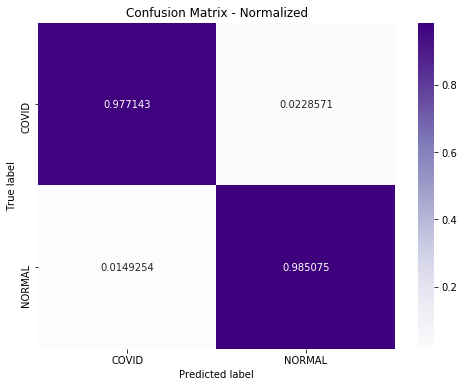

Precision Score: [0.97714286 0.98507463]
Recall Score: [0.97714286 0.98507463]
F1 Score: [0.97714286 0.98507463]
Accuracy Score: 0.981941309255079


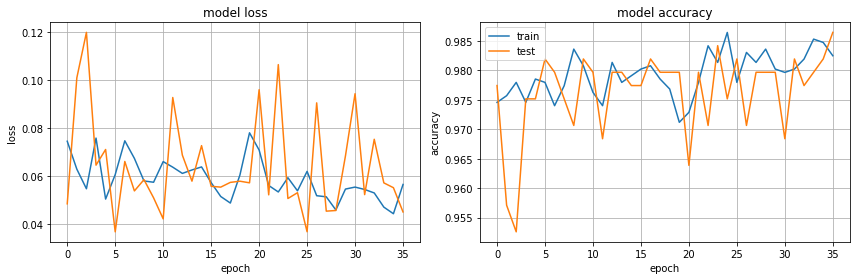

AUC: 0.9811087420042643
Log Loss: 0.036800326117698366


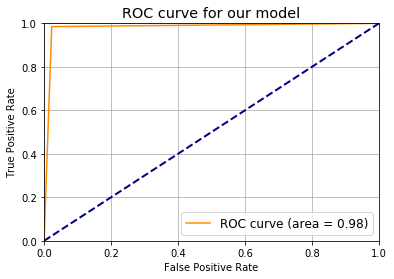

In [20]:
## Confusion matrix
plot_confusion_matrix(model, x_test, y_test)
## Learning curve
plot_learning_curves(history)
## ROC AUC
multiclass_roc_auc_score(x_test, y_test, model)

In [22]:
# saving model
model.save("modelcnd.h5")